In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

station_name = "平台山"
# 读取CSV文件
df = pd.read_csv(f'003-MOD09GA_061_20241204_{station_name}.csv')

# 将日期列转换为datetime格式
df['date'] = pd.to_datetime(df['date'])

# 获取日期范围
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')

# 创建完整的日期DataFrame
complete_df = pd.DataFrame({'date': date_range})

# 与原始数据合并，保留所有日期
df_filled = pd.merge(complete_df, df, on='date', how='left')

# 将缺失值填充为NaN
df_filled = df_filled.fillna(np.nan)

# 读取蓝山嘴站点数据
station_df = pd.read_csv(f'001-{station_name}.csv')
station_df['date'] = pd.to_datetime(station_df['date'])

# 将两个数据集按日期合并
merged_df = pd.merge(df_filled, station_df, on='date', how='left')

# 保存合并后的结果
merged_df.to_csv(f'004-MOD09GA-station-merged_{station_name}.csv', index=False)

print("已完成数据合并，包含遥感特征和蓝山嘴站点数据")


已完成数据合并，包含遥感特征和蓝山嘴站点数据


In [9]:
import numpy as np
import pandas as pd

# 读取CSV文件
# merged_df = pd.read_csv('/root/Download/Modis-algae-aliyun/aie-taihu/特征和密度结果_MODIS_MOD09GA_061_20241106_tuoshan-merged.csv')

# 定义异常值检测规则
anomaly_rules = {
    'evi': {'condition': lambda x: x < -1, 'name': 'EVI'},
    'ndvi': {'condition': lambda x: x < -1, 'name': 'NDVI'}, 
    'ndci': {'condition': lambda x: (x > 1) | (x < -0.2), 'name': 'NDCI'},
    'ndwi': {'condition': lambda x: (x > 1) | (x < -1), 'name': 'NDWI'},
    'nrfi': {'condition': lambda x: x < -1, 'name': 'NRFI'}
}

# 遍历每个指标进行异常值检测和处理
for index, rule in anomaly_rules.items():
    # 找出异常值
    anomaly_mask = rule['condition'](merged_df[index])
    # 将异常值设置为NaN
    merged_df.loc[anomaly_mask, index] = np.nan
    print(f"已将{sum(anomaly_mask)}个{rule['name']}异常值设置为NaN")

# 保存处理后的结果
# merged_df.to_csv('MOD09GA_061_20241106_tuoshan-merged.csv', index=False)
merged_df.to_csv(f'004-MOD09GA-station-merged-异常nan_{station_name}.csv', index=False)

print("异常值处理完成并已保存到CSV文件")


已将74个EVI异常值设置为NaN
已将1个NDVI异常值设置为NaN
已将2个NDCI异常值设置为NaN
已将0个NDWI异常值设置为NaN
已将0个NRFI异常值设置为NaN
异常值处理完成并已保存到CSV文件



藻密度与其他变量的相关性分析:
density         1.000000
temperature     0.661962
fai             0.314635
pH              0.306605
turbidity       0.255009
ndvi            0.245051
chla            0.214907
conductivity    0.214321
TP              0.115551
ndci            0.081110
b2              0.040103
ndwi            0.033809
b4              0.029042
b3              0.021362
b1              0.016912
b5              0.016219
b6             -0.072535
oxygen         -0.075296
NH             -0.101389
b7             -0.120982
evi            -0.142899
permanganate   -0.176410
nrfi           -0.185559
TN             -0.250620
Name: density, dtype: float64


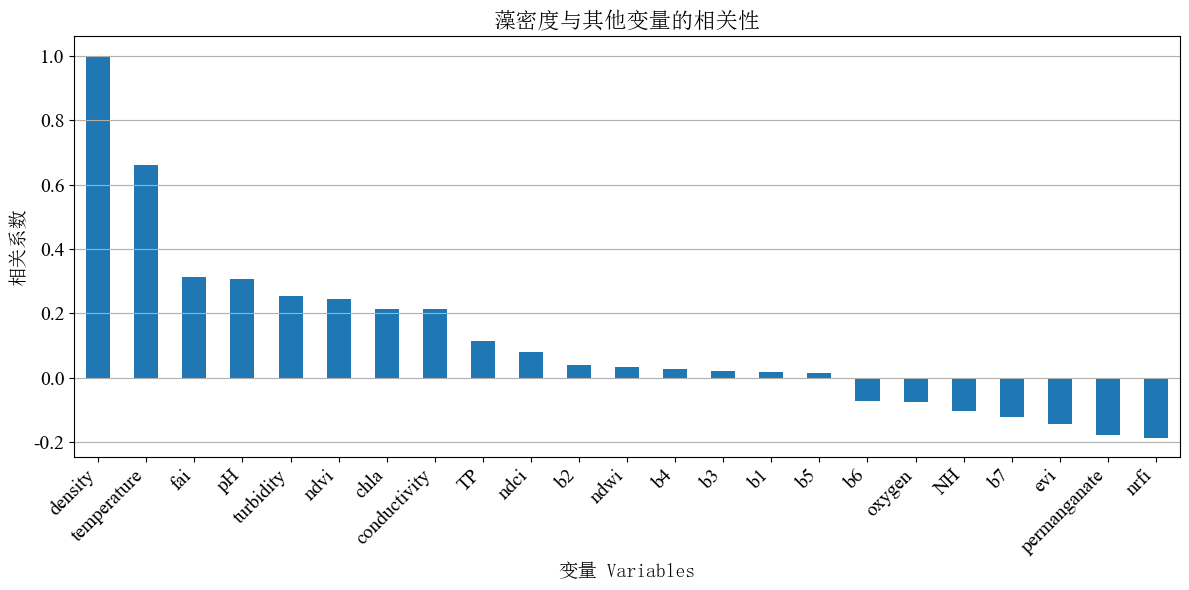


遥感指数与藻密度的相关性分析:
density    1.000000
fai        0.314635
ndvi       0.245051
ndci       0.081110
ndwi       0.033809
evi       -0.142899
nrfi      -0.185559
Name: density, dtype: float64

波段与藻密度的相关性分析:
density    1.000000
b2         0.040103
b4         0.029042
b3         0.021362
b1         0.016912
b5         0.016219
b6        -0.072535
b7        -0.120982
Name: density, dtype: float64


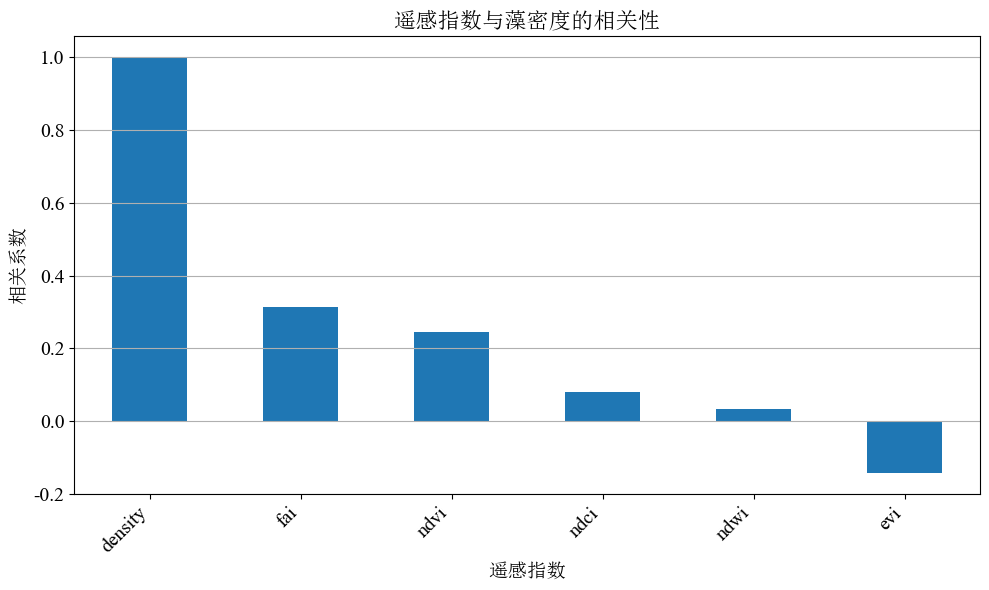

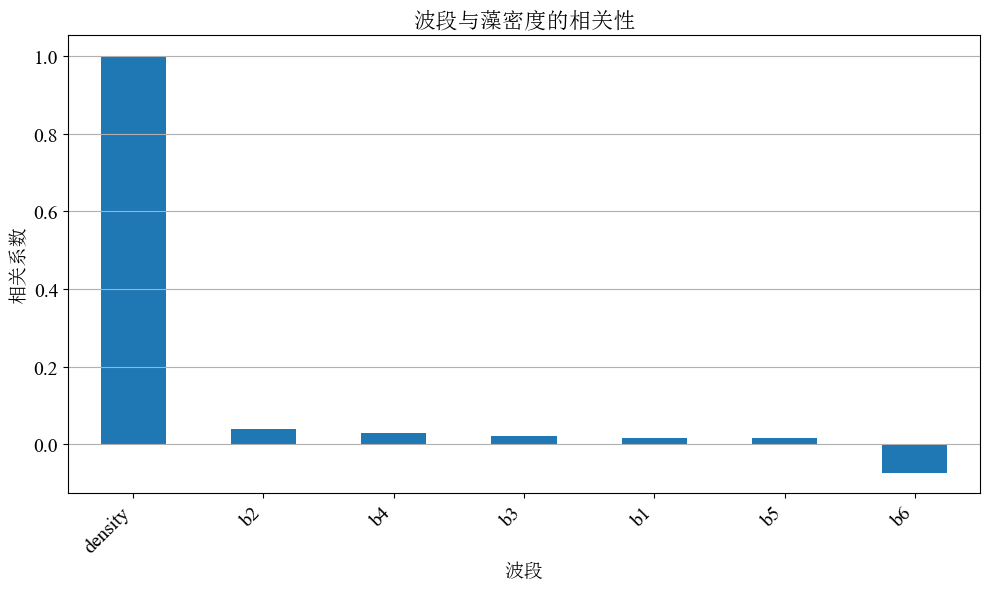

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 设置字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimSun', 'DejaVu Sans']  # 中文字体
plt.rcParams['font.serif'] = ['Times New Roman']  # 英文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 分别设置中英文字体,并设置较大字号
chinese_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/SIMSUN.TTC', size=14)
english_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/TIMES.TTF', size=14)

# 计算藻密度与其他变量的相关性
correlation_vars = ['temperature', 'pH', 'oxygen', 'permanganate', 'NH', 'TP', 'TN', 
                   'conductivity', 'turbidity', 'chla', 'ndci', 'ndvi', 'evi', 'ndwi', 'fai', 'nrfi',
                   'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']  # 添加波段变量
correlations = merged_df[correlation_vars + ['density']].corr()['density'].sort_values(ascending=False)

# 打印相关性结果
print("\n藻密度与其他变量的相关性分析:")
print(correlations)

# 可视化相关性
plt.figure(figsize=(12, 6))
correlations[:-1].plot(kind='bar')
plt.title('藻密度与其他变量的相关性', fontproperties=chinese_font, fontsize=16)
plt.xlabel('变量 Variables', fontproperties=chinese_font, fontsize=14)
plt.ylabel('相关系数', fontproperties=chinese_font, fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 绘制散点图矩阵
import seaborn as sns

# # 选择相关性最强的4个变量,并确保density只出现一次
# top_corr_vars = correlations.index[:4].tolist()
# if 'density' in top_corr_vars:
#     top_corr_vars.remove('density')
# vars_to_plot = top_corr_vars + ['density']

# # 检查数据是否为空
# plot_data = merged_df[vars_to_plot].dropna()
# if not plot_data.empty:
#     plt.figure(figsize=(12, 12))
#     sns.pairplot(plot_data, diag_kind='kde')
#     plt.suptitle('藻密度与主要相关变量的散点图矩阵', y=1.02, fontproperties=chinese_font, fontsize=18)
#     plt.show()
# else:
#     print("数据为空,无法绘制散点图矩阵")

# 计算遥感指数与藻密度的相关性
rs_vars = ['ndci', 'ndvi', 'evi', 'ndwi', 'fai', 'nrfi']
rs_correlations = merged_df[rs_vars + ['density']].corr()['density'].sort_values(ascending=False)

# 计算波段与藻密度的相关性
band_vars = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']
band_correlations = merged_df[band_vars + ['density']].corr()['density'].sort_values(ascending=False)

print("\n遥感指数与藻密度的相关性分析:")
print(rs_correlations)

print("\n波段与藻密度的相关性分析:")
print(band_correlations)

# 可视化遥感指数相关性
plt.figure(figsize=(10, 6))
rs_correlations[:-1].plot(kind='bar')
plt.title('遥感指数与藻密度的相关性', fontproperties=chinese_font, fontsize=16)
plt.xlabel('遥感指数', fontproperties=chinese_font, fontsize=14)
plt.ylabel('相关系数', fontproperties=chinese_font, fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 可视化波段相关性
plt.figure(figsize=(10, 6))
band_correlations[:-1].plot(kind='bar')
plt.title('波段与藻密度的相关性', fontproperties=chinese_font, fontsize=16)
plt.xlabel('波段', fontproperties=chinese_font, fontsize=14)
plt.ylabel('相关系数', fontproperties=chinese_font, fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


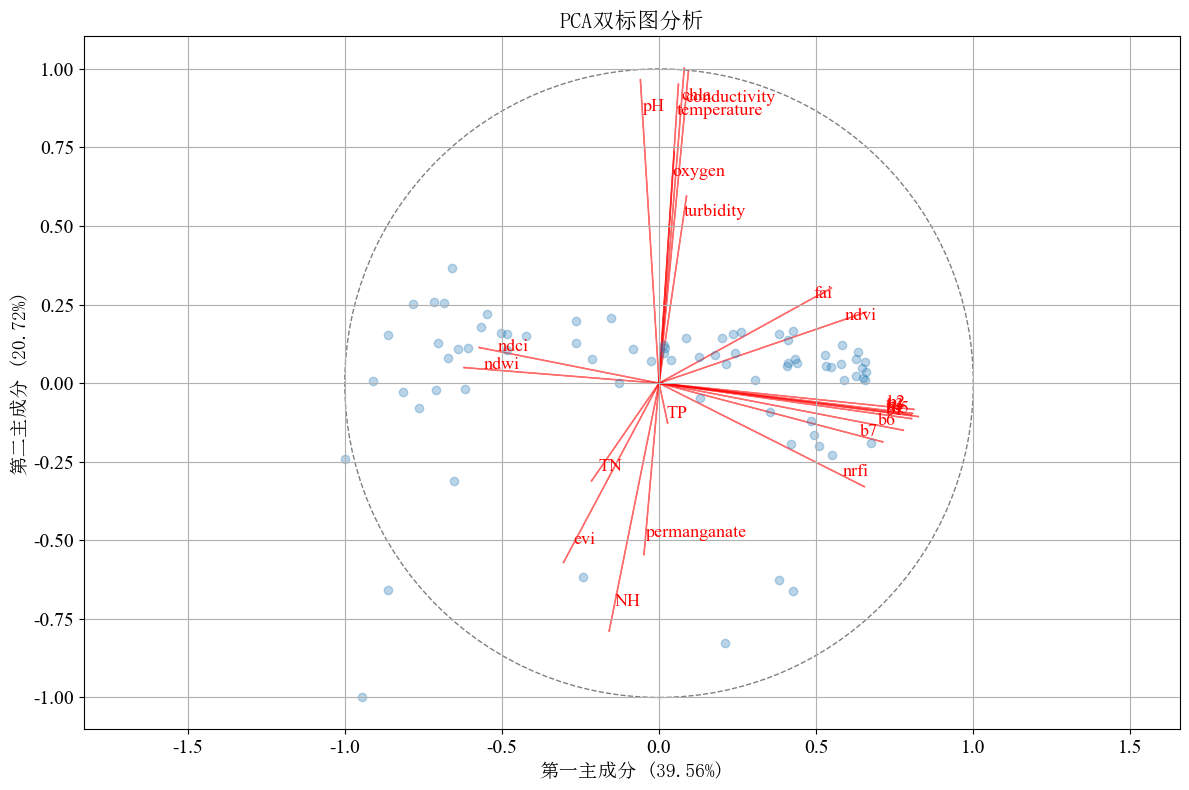

In [11]:
# 进行PCA分析
# 选择要进行PCA分析的变量
pca_vars = correlation_vars  # 使用之前定义的所有变量

# 准备数据
X = merged_df[pca_vars].dropna()
X_scaled = StandardScaler().fit_transform(X)

# 执行PCA
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# 计算解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_

# 绘制PCA双标图
plt.figure(figsize=(12, 8))
scale = np.max(np.abs(pca.components_[:2]))

# 绘制变量向量
for i, var in enumerate(pca_vars):
    plt.arrow(0, 0,
              pca.components_[0, i] / scale,
              pca.components_[1, i] / scale,
              color='r', alpha=0.5)
    # 调整文本位置,使用0.9而不是1.15,防止文本出界
    plt.text(pca.components_[0, i] / scale * 0.9,
             pca.components_[1, i] / scale * 0.9,
             var, color='r', fontproperties=english_font, fontsize=13)  # 减小字体大小

# 绘制样本点
plt.scatter(pca_result[:, 0] / np.max(np.abs(pca_result[:, 0])),
            pca_result[:, 1] / np.max(np.abs(pca_result[:, 1])),
            alpha=0.3)

# 添加标题和轴标签
plt.title('PCA双标图分析', fontproperties=chinese_font, fontsize=16)
plt.xlabel(f'第一主成分 ({explained_variance_ratio[0]:.2%})', fontproperties=chinese_font, fontsize=14)
plt.ylabel(f'第二主成分 ({explained_variance_ratio[1]:.2%})', fontproperties=chinese_font, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)

# 添加单位圆
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
plt.gca().add_artist(circle)
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


叶绿素与其他变量的相关性分析:
chla            1.000000
conductivity    0.966333
oxygen          0.878398
pH              0.711648
temperature     0.519618
turbidity       0.328280
density         0.214907
ndvi            0.035108
fai             0.035041
ndci            0.025821
b6              0.008787
b7              0.008523
b5             -0.013939
b2             -0.018843
permanganate   -0.018854
b3             -0.021109
b4             -0.024310
b1             -0.029423
ndwi           -0.032116
TP             -0.054618
nrfi           -0.120902
TN             -0.148955
NH             -0.206169
evi            -0.386842
Name: chla, dtype: float64


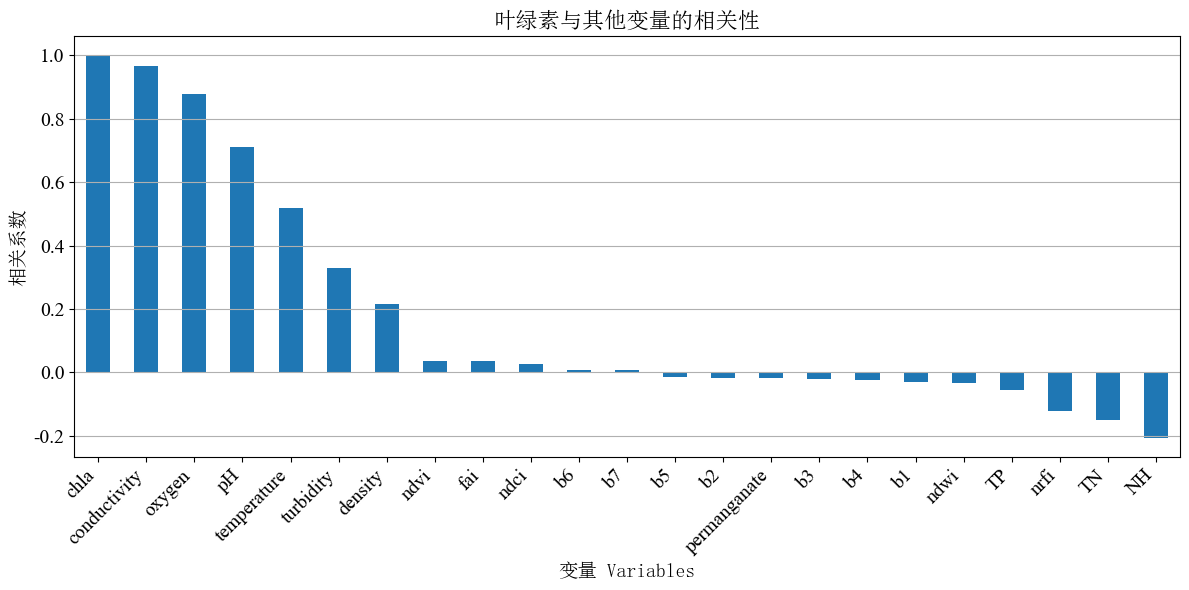


遥感指数与叶绿素的相关性分析:
chla    1.000000
ndvi    0.035108
fai     0.035041
ndci    0.025821
ndwi   -0.032116
nrfi   -0.120902
evi    -0.386842
Name: chla, dtype: float64

波段与叶绿素的相关性分析:
chla    1.000000
b6      0.008787
b7      0.008523
b5     -0.013939
b2     -0.018843
b3     -0.021109
b4     -0.024310
b1     -0.029423
Name: chla, dtype: float64


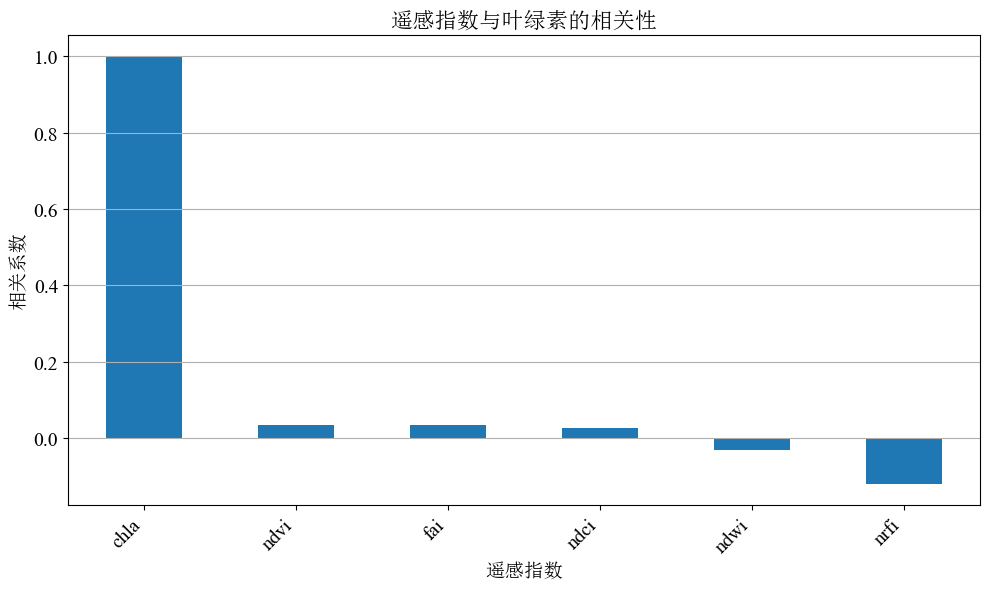

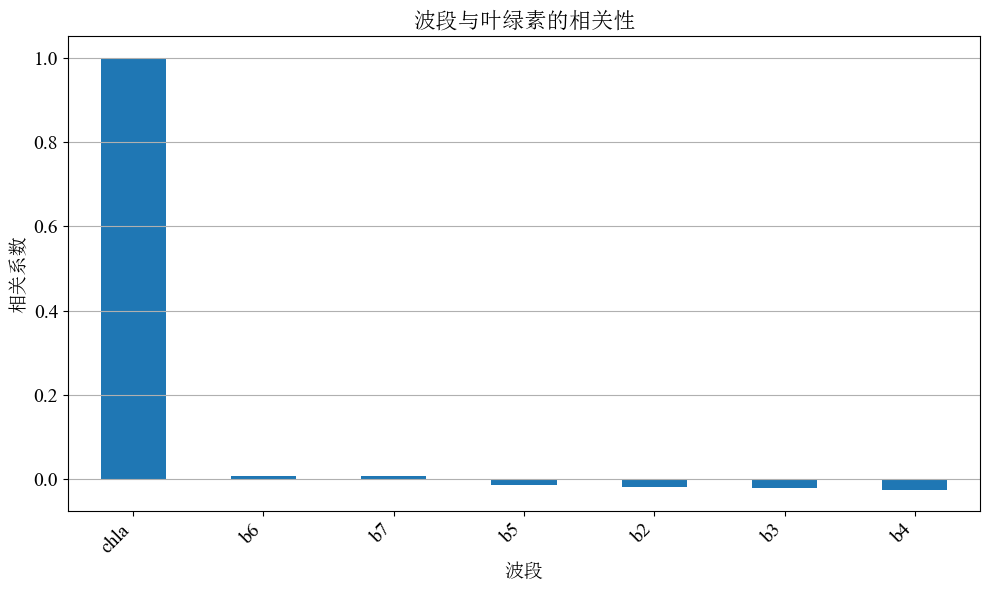

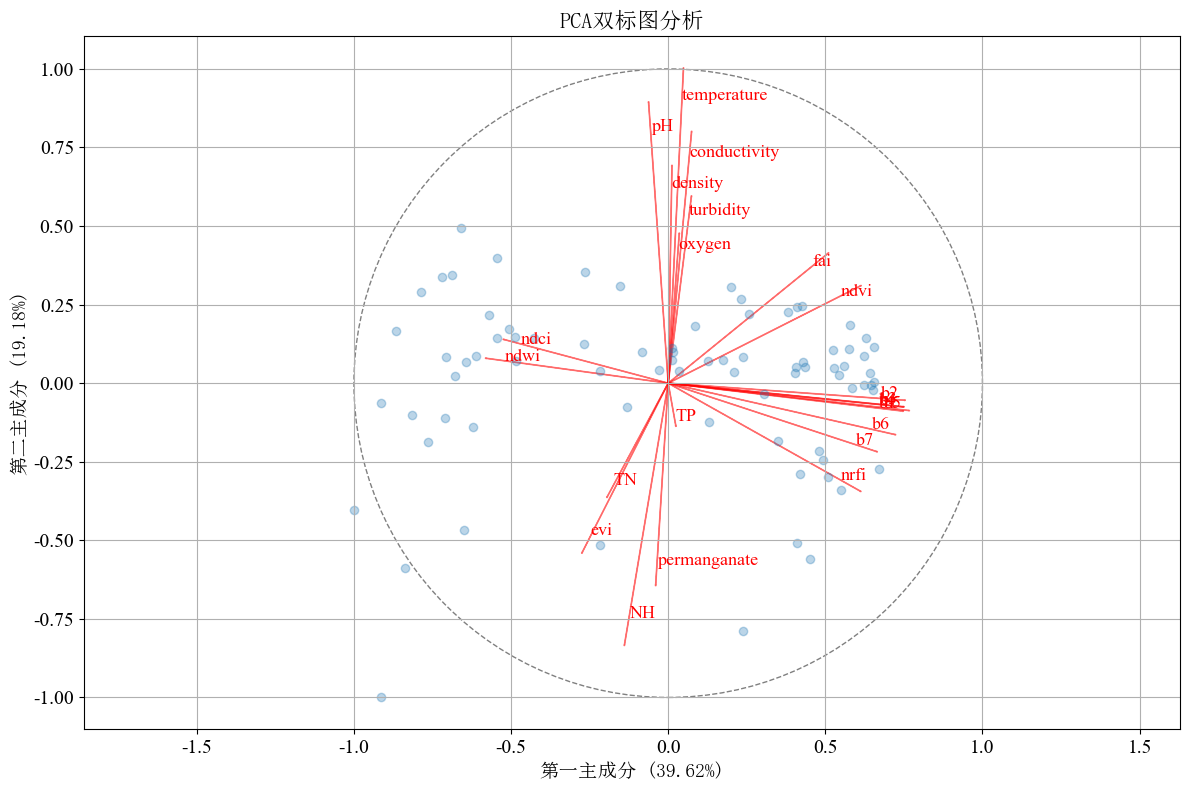

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 设置字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimSun', 'DejaVu Sans']  # 中文字体
plt.rcParams['font.serif'] = ['Times New Roman']  # 英文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 分别设置中英文字体,并设置较大字号
chinese_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/SIMSUN.TTC', size=14)
english_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/TIMES.TTF', size=14)

# 读取数据
# merged_df = pd.read_csv('/root/Download/Modis-algae-aliyun/aie-taihu/特征和密度结果_MODIS_MOD09GA_061_20241106_tuoshan-merged.csv')

# 计算叶绿素与其他变量的相关性
correlation_vars = ['temperature', 'pH', 'oxygen', 'permanganate', 'NH', 'TP', 'TN', 
                   'conductivity', 'turbidity', 'density', 'ndci', 'ndvi', 'evi', 'ndwi', 'fai', 'nrfi',
                   'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']  # 添加波段变量
correlations = merged_df[correlation_vars + ['chla']].corr()['chla'].sort_values(ascending=False)

# 打印相关性结果
print("\n叶绿素与其他变量的相关性分析:")
print(correlations)

# 可视化相关性
plt.figure(figsize=(12, 6))
correlations[:-1].plot(kind='bar')
plt.title('叶绿素与其他变量的相关性', fontproperties=chinese_font, fontsize=16)
plt.xlabel('变量 Variables', fontproperties=chinese_font, fontsize=14)
plt.ylabel('相关系数', fontproperties=chinese_font, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='both', which='major', labelsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 绘制散点图矩阵
import seaborn as sns

# 计算遥感指数与叶绿素的相关性
rs_vars = ['ndci', 'ndvi', 'evi', 'ndwi', 'fai', 'nrfi']
rs_correlations = merged_df[rs_vars + ['chla']].corr()['chla'].sort_values(ascending=False)

# 计算波段与叶绿素的相关性
band_vars = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']
band_correlations = merged_df[band_vars + ['chla']].corr()['chla'].sort_values(ascending=False)

print("\n遥感指数与叶绿素的相关性分析:")
print(rs_correlations)

print("\n波段与叶绿素的相关性分析:")
print(band_correlations)

# 可视化遥感指数相关性
plt.figure(figsize=(10, 6))
rs_correlations[:-1].plot(kind='bar')
plt.title('遥感指数与叶绿素的相关性', fontproperties=chinese_font, fontsize=16)
plt.xlabel('遥感指数', fontproperties=chinese_font, fontsize=14)
plt.ylabel('相关系数', fontproperties=chinese_font, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='both', which='major', labelsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 可视化波段相关性
plt.figure(figsize=(10, 6))
band_correlations[:-1].plot(kind='bar')
plt.title('波段与叶绿素的相关性', fontproperties=chinese_font, fontsize=16)
plt.xlabel('波段', fontproperties=chinese_font, fontsize=14)
plt.ylabel('相关系数', fontproperties=chinese_font, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='both', which='major', labelsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 进行PCA分析
# 选择要进行PCA分析的变量
pca_vars = correlation_vars  # 使用之前定义的所有变量

# 准备数据
X = merged_df[pca_vars].dropna()
X_scaled = StandardScaler().fit_transform(X)

# 执行PCA
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# 计算解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_

# 绘制PCA双标图
plt.figure(figsize=(12, 8))
scale = np.max(np.abs(pca.components_[:2]))

# 绘制变量向量
for i, var in enumerate(pca_vars):
    plt.arrow(0, 0,
              pca.components_[0, i] / scale,
              pca.components_[1, i] / scale,
              color='r', alpha=0.5)
    # 调整文本位置,使用0.9而不是1.15,防止文本出界
    plt.text(pca.components_[0, i] / scale * 0.9,
             pca.components_[1, i] / scale * 0.9,
             var, color='r', fontproperties=english_font, fontsize=13)  # 减小字体大小

# 绘制样本点
plt.scatter(pca_result[:, 0] / np.max(np.abs(pca_result[:, 0])),
            pca_result[:, 1] / np.max(np.abs(pca_result[:, 1])),
            alpha=0.3)

# 添加标题和轴标签
plt.title('PCA双标图分析', fontproperties=chinese_font, fontsize=16)
plt.xlabel(f'第一主成分 ({explained_variance_ratio[0]:.2%})', fontproperties=chinese_font, fontsize=14)
plt.ylabel(f'第二主成分 ({explained_variance_ratio[1]:.2%})', fontproperties=chinese_font, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)

# 添加单位圆
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
plt.gca().add_artist(circle)
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.

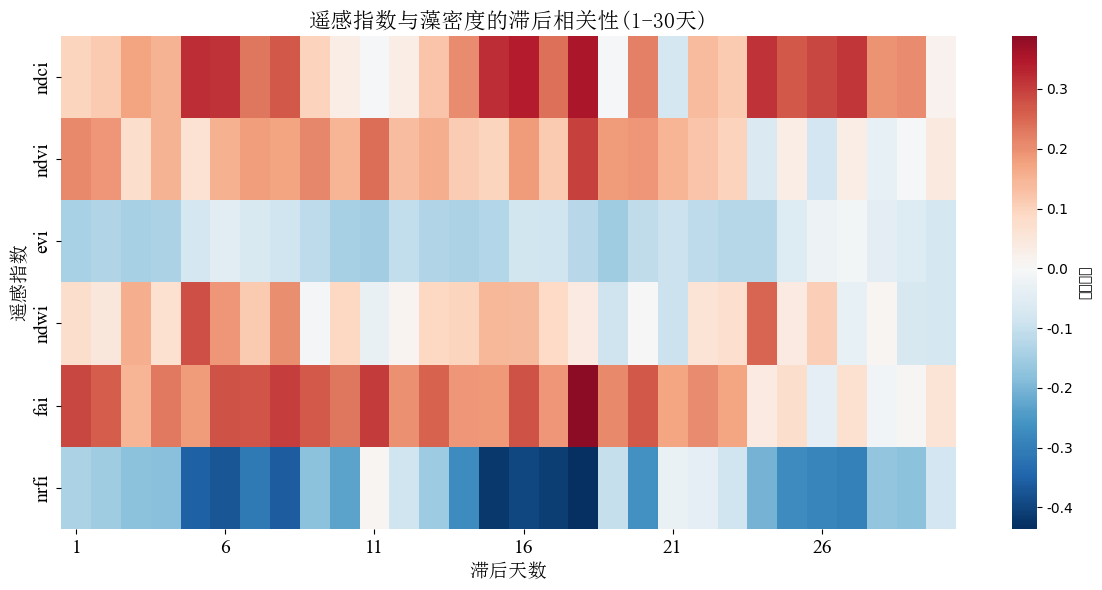

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.

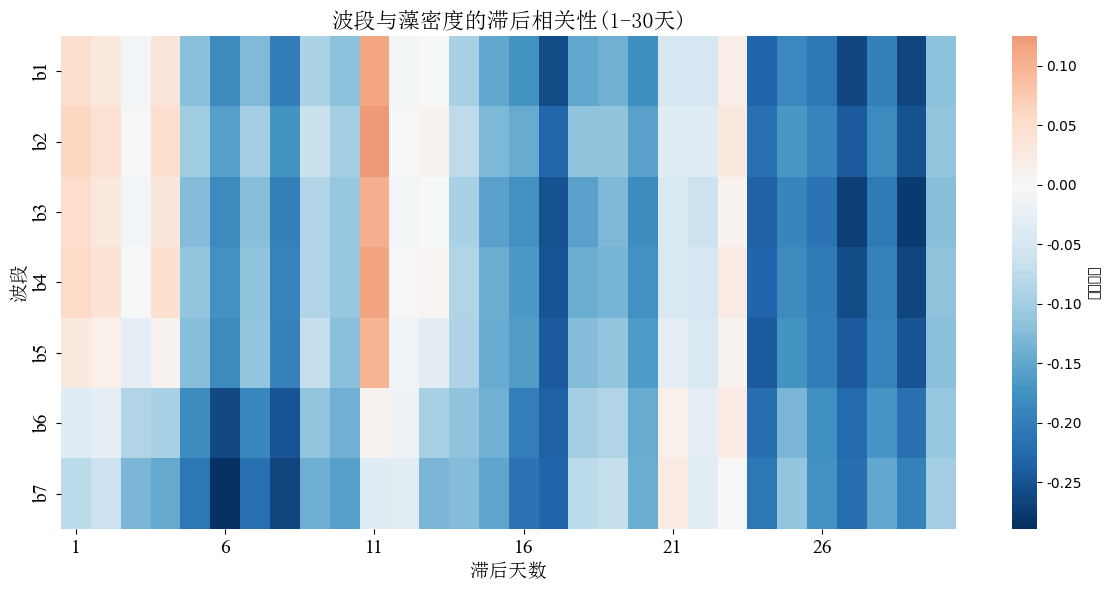


遥感指数的最大滞后相关性及对应滞后天数:
ndci: 相关系数 = 0.353, 滞后天数 = 18
ndvi: 相关系数 = 0.298, 滞后天数 = 18
evi: 相关系数 = -0.154, 滞后天数 = 19
ndwi: 相关系数 = 0.281, 滞后天数 = 5
fai: 相关系数 = 0.389, 滞后天数 = 18
nrfi: 相关系数 = -0.436, 滞后天数 = 18

波段的最大滞后相关性及对应滞后天数:
b1: 相关系数 = -0.266, 滞后天数 = 29
b2: 相关系数 = -0.251, 滞后天数 = 29
b3: 相关系数 = -0.276, 滞后天数 = 29
b4: 相关系数 = -0.264, 滞后天数 = 29
b5: 相关系数 = -0.250, 滞后天数 = 29
b6: 相关系数 = -0.260, 滞后天数 = 6
b7: 相关系数 = -0.289, 滞后天数 = 6


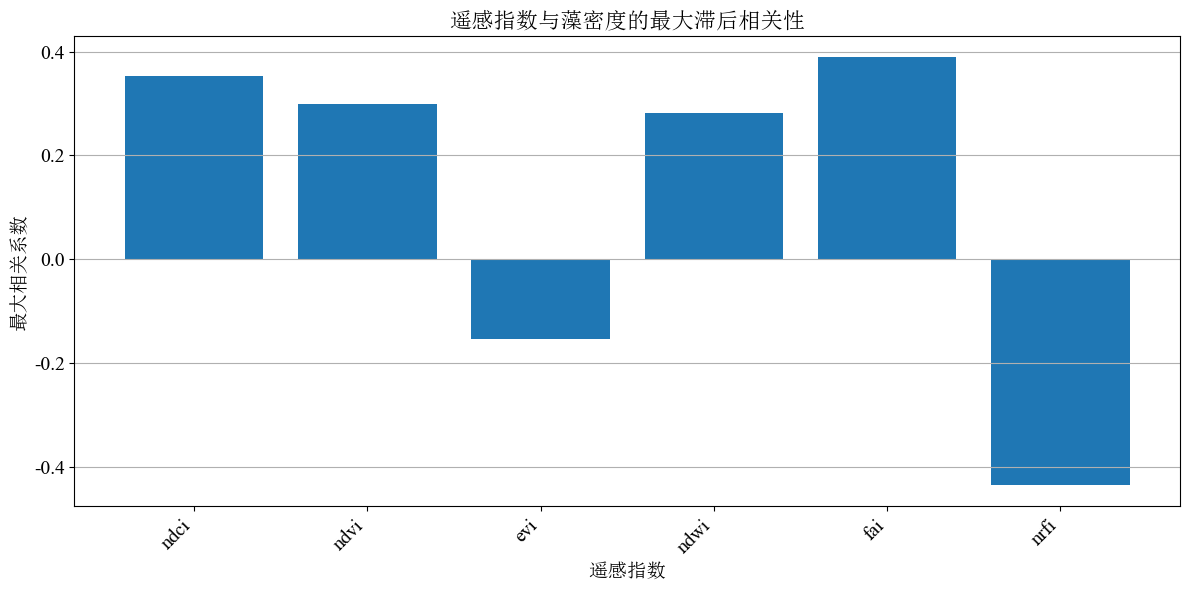

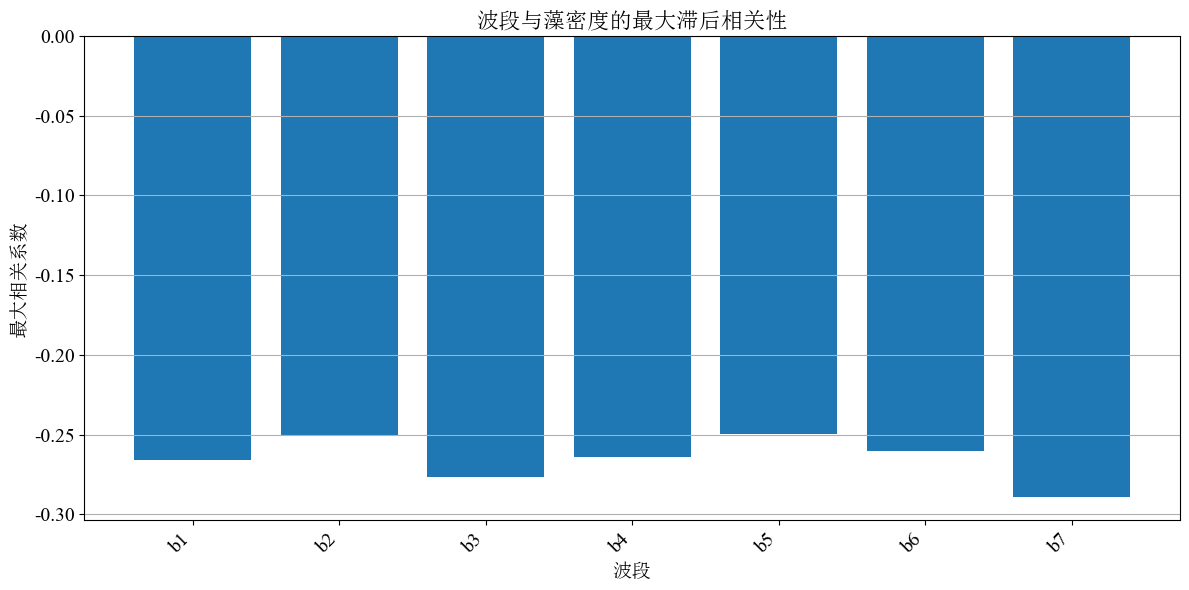

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 设置字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimSun', 'DejaVu Sans']  # 中文字体
plt.rcParams['font.serif'] = ['Times New Roman']  # 英文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 分别设置中英文字体,并设置较大字号
chinese_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/SIMSUN.TTC', size=14)
english_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/TIMES.TTF', size=14)

# 定义遥感指数和波段变量
rs_vars = ['ndci', 'ndvi', 'evi', 'ndwi', 'fai', 'nrfi']
band_vars = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']

# 计算滞后相关性
max_lag = 30  # 最大滞后天数

# 遥感指数的滞后相关性分析
rs_lag_correlations = {}
for var in rs_vars:
    lag_corrs = []
    for lag in range(1, max_lag + 1):
        lagged_corr = merged_df[var].shift(lag).corr(merged_df['density'])
        lag_corrs.append(lagged_corr)
    rs_lag_correlations[var] = lag_corrs

# 波段的滞后相关性分析
band_lag_correlations = {}
for var in band_vars:
    lag_corrs = []
    for lag in range(1, max_lag + 1):
        lagged_corr = merged_df[var].shift(lag).corr(merged_df['density'])
        lag_corrs.append(lagged_corr)
    band_lag_correlations[var] = lag_corrs

# 绘制遥感指数滞后相关性热力图
plt.figure(figsize=(12, 6))
rs_lag_data = pd.DataFrame(rs_lag_correlations, index=range(1, max_lag + 1))
sns.heatmap(rs_lag_data.T, cmap='RdBu_r', center=0,
            xticklabels=5,
            cbar_kws={'label': '相关系数'})
plt.title('遥感指数与藻密度的滞后相关性(1-30天)', fontproperties=chinese_font, fontsize=16)
plt.xlabel('滞后天数', fontproperties=chinese_font, fontsize=14)
plt.ylabel('遥感指数', fontproperties=chinese_font, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.tight_layout()
plt.show()

# 绘制波段滞后相关性热力图
plt.figure(figsize=(12, 6))
band_lag_data = pd.DataFrame(band_lag_correlations, index=range(1, max_lag + 1))
sns.heatmap(band_lag_data.T, cmap='RdBu_r', center=0,
            xticklabels=5,
            cbar_kws={'label': '相关系数'})
plt.title('波段与藻密度的滞后相关性(1-30天)', fontproperties=chinese_font, fontsize=16)
plt.xlabel('滞后天数', fontproperties=chinese_font, fontsize=14)
plt.ylabel('波段', fontproperties=chinese_font, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.tight_layout()
plt.show()

# 找出遥感指数的最大滞后相关性
rs_max_lag_correlations = {}
for var in rs_vars:
    max_corr = max(rs_lag_correlations[var], key=abs)
    max_lag = rs_lag_correlations[var].index(max_corr) + 1
    rs_max_lag_correlations[var] = (max_corr, max_lag)

# 找出波段的最大滞后相关性
band_max_lag_correlations = {}
for var in band_vars:
    max_corr = max(band_lag_correlations[var], key=abs)
    max_lag = band_lag_correlations[var].index(max_corr) + 1
    band_max_lag_correlations[var] = (max_corr, max_lag)

print("\n遥感指数的最大滞后相关性及对应滞后天数:")
for var, (corr, lag) in rs_max_lag_correlations.items():
    print(f"{var}: 相关系数 = {corr:.3f}, 滞后天数 = {lag}")

print("\n波段的最大滞后相关性及对应滞后天数:")
for var, (corr, lag) in band_max_lag_correlations.items():
    print(f"{var}: 相关系数 = {corr:.3f}, 滞后天数 = {lag}")

# 绘制遥感指数最大滞后相关性柱状图
plt.figure(figsize=(12, 6))
rs_max_corrs = [corr for corr, _ in rs_max_lag_correlations.values()]
plt.bar(rs_max_lag_correlations.keys(), rs_max_corrs)
plt.title('遥感指数与藻密度的最大滞后相关性', fontproperties=chinese_font, fontsize=16)
plt.xlabel('遥感指数', fontproperties=chinese_font, fontsize=14)
plt.ylabel('最大相关系数', fontproperties=chinese_font, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='both', which='major', labelsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 绘制波段最大滞后相关性柱状图
plt.figure(figsize=(12, 6))
band_max_corrs = [corr for corr, _ in band_max_lag_correlations.values()]
plt.bar(band_max_lag_correlations.keys(), band_max_corrs)
plt.title('波段与藻密度的最大滞后相关性', fontproperties=chinese_font, fontsize=16)
plt.xlabel('波段', fontproperties=chinese_font, fontsize=14)
plt.ylabel('最大相关系数', fontproperties=chinese_font, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='both', which='major', labelsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.

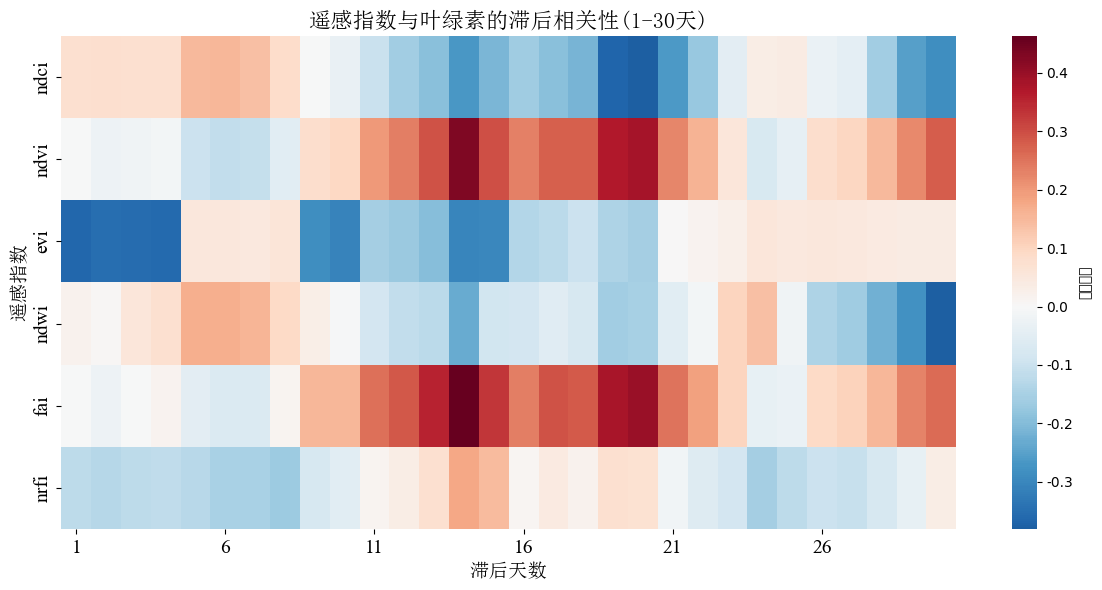

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.

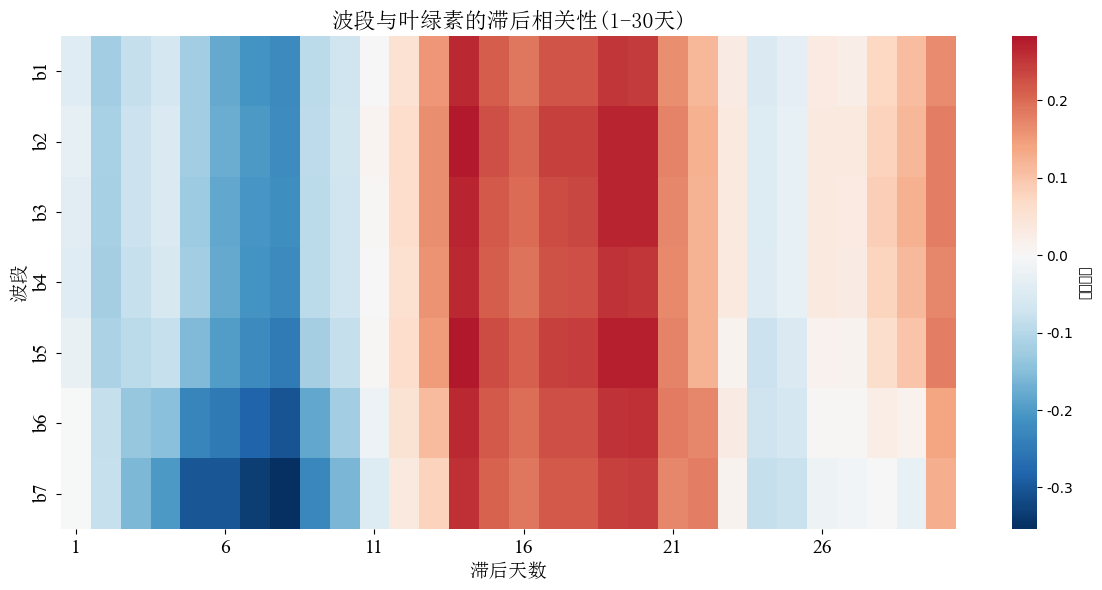


遥感指数的最大滞后相关性及对应滞后天数:
ndci: 相关系数 = -0.378, 滞后天数 = 20
ndvi: 相关系数 = 0.430, 滞后天数 = 14
evi: 相关系数 = -0.364, 滞后天数 = 1
ndwi: 相关系数 = -0.380, 滞后天数 = 30
fai: 相关系数 = 0.462, 滞后天数 = 14
nrfi: 相关系数 = 0.179, 滞后天数 = 14

波段的最大滞后相关性及对应滞后天数:
b1: 相关系数 = 0.263, 滞后天数 = 14
b2: 相关系数 = 0.279, 滞后天数 = 14
b3: 相关系数 = 0.269, 滞后天数 = 14
b4: 相关系数 = 0.264, 滞后天数 = 14
b5: 相关系数 = 0.283, 滞后天数 = 14
b6: 相关系数 = -0.305, 滞后天数 = 8
b7: 相关系数 = -0.353, 滞后天数 = 8


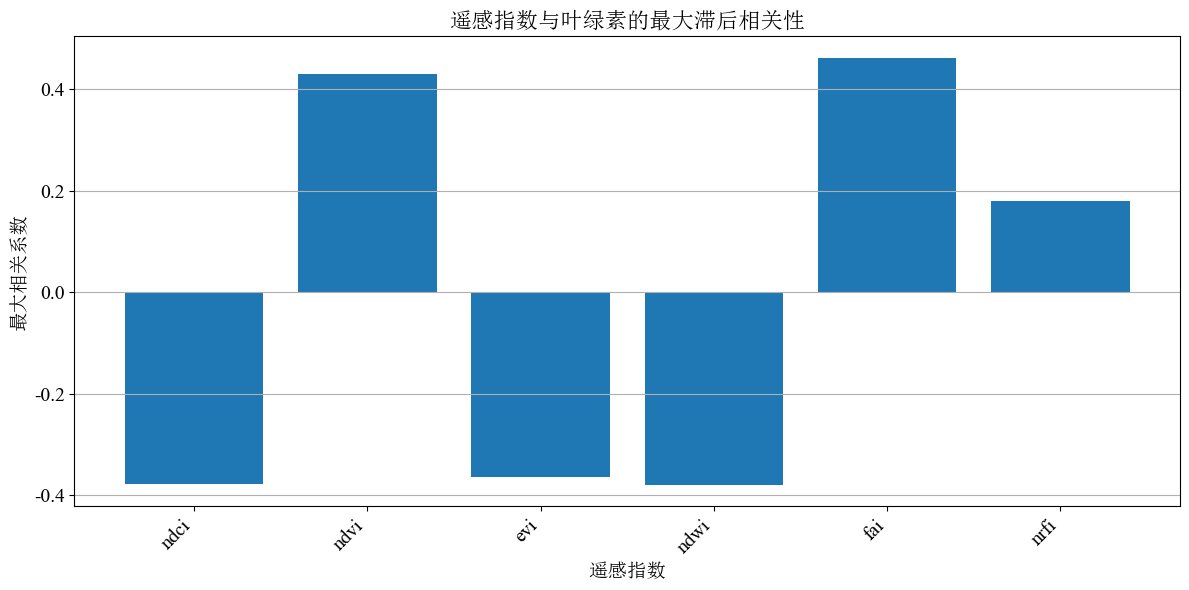

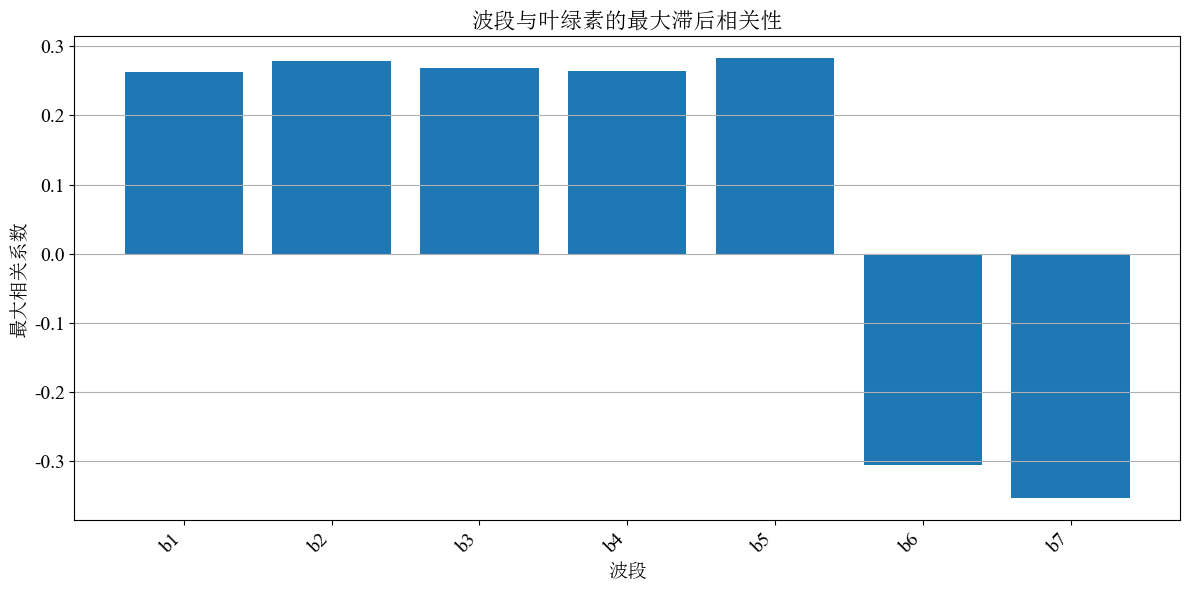

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 设置字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimSun', 'DejaVu Sans']  # 中文字体
plt.rcParams['font.serif'] = ['Times New Roman']  # 英文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 分别设置中英文字体,并设置较大字号
chinese_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/SIMSUN.TTC', size=14)
english_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/TIMES.TTF', size=14)

# 读取数据
# merged_df = pd.read_csv('/root/Download/Modis-algae-aliyun/aie-taihu/特征和密度结果_MODIS_MOD09GA_061_20241106_tuoshan-merged.csv')

# 定义遥感指数和波段变量
rs_vars = ['ndci', 'ndvi', 'evi', 'ndwi', 'fai', 'nrfi']
band_vars = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']

# 计算滞后相关性
max_lag = 30  # 最大滞后天数

# 遥感指数的滞后相关性分析
rs_lag_correlations = {}
for var in rs_vars:
    lag_corrs = []
    for lag in range(1, max_lag + 1):
        lagged_corr = merged_df[var].shift(lag).corr(merged_df['chla'])
        lag_corrs.append(lagged_corr)
    rs_lag_correlations[var] = lag_corrs

# 波段的滞后相关性分析
band_lag_correlations = {}
for var in band_vars:
    lag_corrs = []
    for lag in range(1, max_lag + 1):
        lagged_corr = merged_df[var].shift(lag).corr(merged_df['chla'])
        lag_corrs.append(lagged_corr)
    band_lag_correlations[var] = lag_corrs

# 绘制遥感指数滞后相关性热力图
plt.figure(figsize=(12, 6))
rs_lag_data = pd.DataFrame(rs_lag_correlations, index=range(1, max_lag + 1))
sns.heatmap(rs_lag_data.T, cmap='RdBu_r', center=0,
            xticklabels=5,
            cbar_kws={'label': '相关系数'})
plt.title('遥感指数与叶绿素的滞后相关性(1-30天)', fontproperties=chinese_font, fontsize=16)
plt.xlabel('滞后天数', fontproperties=chinese_font, fontsize=14)
plt.ylabel('遥感指数', fontproperties=chinese_font, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.tight_layout()
plt.show()

# 绘制波段滞后相关性热力图
plt.figure(figsize=(12, 6))
band_lag_data = pd.DataFrame(band_lag_correlations, index=range(1, max_lag + 1))
sns.heatmap(band_lag_data.T, cmap='RdBu_r', center=0,
            xticklabels=5,
            cbar_kws={'label': '相关系数'})
plt.title('波段与叶绿素的滞后相关性(1-30天)', fontproperties=chinese_font, fontsize=16)
plt.xlabel('滞后天数', fontproperties=chinese_font, fontsize=14)
plt.ylabel('波段', fontproperties=chinese_font, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.tight_layout()
plt.show()

# 找出遥感指数的最大滞后相关性
rs_max_lag_correlations = {}
for var in rs_vars:
    max_corr = max(rs_lag_correlations[var], key=abs)
    max_lag = rs_lag_correlations[var].index(max_corr) + 1
    rs_max_lag_correlations[var] = (max_corr, max_lag)

# 找出波段的最大滞后相关性
band_max_lag_correlations = {}
for var in band_vars:
    max_corr = max(band_lag_correlations[var], key=abs)
    max_lag = band_lag_correlations[var].index(max_corr) + 1
    band_max_lag_correlations[var] = (max_corr, max_lag)

print("\n遥感指数的最大滞后相关性及对应滞后天数:")
for var, (corr, lag) in rs_max_lag_correlations.items():
    print(f"{var}: 相关系数 = {corr:.3f}, 滞后天数 = {lag}")

print("\n波段的最大滞后相关性及对应滞后天数:")
for var, (corr, lag) in band_max_lag_correlations.items():
    print(f"{var}: 相关系数 = {corr:.3f}, 滞后天数 = {lag}")

# 绘制遥感指数最大滞后相关性柱状图
plt.figure(figsize=(12, 6))
rs_max_corrs = [corr for corr, _ in rs_max_lag_correlations.values()]
plt.bar(rs_max_lag_correlations.keys(), rs_max_corrs)
plt.title('遥感指数与叶绿素的最大滞后相关性', fontproperties=chinese_font, fontsize=16)
plt.xlabel('遥感指数', fontproperties=chinese_font, fontsize=14)
plt.ylabel('最大相关系数', fontproperties=chinese_font, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='both', which='major', labelsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 绘制波段最大滞后相关性柱状图
plt.figure(figsize=(12, 6))
band_max_corrs = [corr for corr, _ in band_max_lag_correlations.values()]
plt.bar(band_max_lag_correlations.keys(), band_max_corrs)
plt.title('波段与叶绿素的最大滞后相关性', fontproperties=chinese_font, fontsize=16)
plt.xlabel('波段', fontproperties=chinese_font, fontsize=14)
plt.ylabel('最大相关系数', fontproperties=chinese_font, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='both', which='major', labelsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(english_font)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()